(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Recommender System for Amazon Electronics

In this assignment, we will be working with the [Amazon dataset](http://cs-people.bu.edu/kzhao/teaching/amazon_reviews_Electronics.tar.gz). You will build a recommender system to make predictions related to reviews of Electronics products on Amazon.

Your grades will be determined by your performance on the predictive tasks as well as a brief written report about the approaches you took.

This assignment should be completed **individually**.

## Files

**train.json** 1,000,000 reviews to be used for training. It is not necessary to use all reviews for training if doing so proves too computationally intensive. The fields in this file are:

* **reviewerID** The ID of the reviewer. This is a hashed user identifier from Amazon.

* **asin** The ID of the item. This is a hashed product identifier from Amazon.

* **overall** The rating of reviewer gave the item.

* **helpful** The helpfulness votes for the review. This has 2 subfields, 'nHelpful' and 'outOf'. The latter is the total number of votes this review received. The former is the number of those that considered the review to be helpful.

* **reviewText** The text of the review.

* **summary** The summary of the review.

* **unixReviewTime** The time of the review in seconds since 1970.

**meta.json** Contains metadata of the items:

* **asin** The ID of the item.

* **categories** The category labels of the item being reviewed.

* **price** The price of the item.

* **brand** The brand of the item.

**pairs_Rating.txt** The pairs (reviewerID and asin) on which you are to predict ratings.

**pairs_Purchase.txt** The pairs on which you are to predict whether a user purchased an item or not.

**pairs_Helpful.txt** The pairs on which you are to predict helpfulness votes. A third column in this file is the total number of votes from which you should predict how many were helpful.

**helpful.json** The review data associated with the helpfulness prediction test set. The 'nHelpful' field has been removed from this data since that is the value you need to predict above. This data will only be of use for the helpfulness prediction task.

**baseline.py** A simple baseline for each task.

## Tasks

**Rating prediction** Predict people's star ratings as accurately as possible for those (reviewerID, asin) pairs in 'pairs_Rating.txt'. Accuracy will be measured in terms of the [root mean-squared error (RMSE)](http://www.kaggle.com/wiki/RootMeanSquaredError).

**Purchase prediction** Predict given a (reviewerID, asin) pair from 'pairs_Purchase.txt' whether the user purchased the item (really, whether it was one of the items they reviewed). Accuracy will be measured in terms of the [categorization accuracy](http://www.kaggle.com/wiki/HammingLoss) (1 minus the Hamming loss).

**Helpfulness prediction** Predic whether a user's review of an item will be considered helpful. The file 'pairs_Helpful.txt' contains (reviewerID, asin) pairs with a third column containing the number of votes the user's review of the item received. You must predict how many of them were helpful. Accuracy will be measured in terms of the total [absolute error](http://www.kaggle.com/wiki/AbsoluteError), i.e. you are penalized one according to the difference |nHelpful - prediction|, where 'nHelpful' is the number of helpful votes the review actually received, and 'prediction' is your prediction of this quantity.

We set up competitions on Kaggle to keep track of your results compared to those of other members of the class. The leaderboard will show your results on half of the test data, but your ultimate score will depend on your predictions across the whole dataset.
* Kaggle competition: [rating prediction](https://inclass.kaggle.com/c/cs591-hw3-rating-prediction3) click here to [join](https://kaggle.com/join/datascience16rating)
* Kaggle competition: [purchase prediction](https://inclass.kaggle.com/c/cs591-hw3-purchase-prediction) click here to [join](https://kaggle.com/join/datascience16purchase)
* Kaggle competition: [helpfulness prediction](https://inclass.kaggle.com/c/cs591-hw3-helpful-prediction) click here to [join](https://kaggle.com/join/datascience16helpful)

## Grading and Evaluation

You will be graded on the following aspects.

* Your written report. This should describe the approaches you took to each of the 3 tasks. To obtain good performance, you should not need to invent new approaches (though you are more than welcome to) but rather you will be graded based on your decision to apply reasonable approaches to each of the given tasks. (**10pts** for each task)

* Your ability to obtain a solution which outperforms the baselines on the unseen portion of the test data. Obtaining full marks requires a solution which is substantially better (at least several percent) than baseline performance. (**10pts** for each task)

* Your ranking for each of the three tasks compared to other students in the class. (**5pts** for each task)

* Obtain a solution which outperforms the baselines on the seen portion of the test data (the leaderboard). 
(**5pts** for each task)

## Baselines

Simple baselines have been provided for each of the 3 tasks. These are included in 'baselines.py' among the files above. These 3 baselines operate as follows:

**Rating prediction** Returns the global average rating, or the user's average if you have seen them before in the training data.

**Purchase prediction** Finds the most popular products that account for 50% of purchases in the training data. Return '1' whenever such a product is seen at test time, '0' otherwise.

** Helpfulness prediction** Multiplies the number of votes by the global average helpfulness rate, or the user's rate if we saw this user in the training data.

Running 'baseline.py' produces 3 files containing predicted outputs. Your submission files should have the same format.

## Dataset Citation

**Image-based recommendations on styles and substitutes** J. McAuley, C. Targett, J. Shi, A. van den Hengel *SIGIR*, 2015

**Inferring networks of substitutable and complementary products** J. McAuley, R. Pandey, J. Leskovec *Knowledge Discovery and Data Mining*, 2015

-----------------

In [32]:
#Baseline code for Rating Prediction
from collections import defaultdict

def readJson(f):
    for l in open(f):
        yield eval(l)

### Rating baseline: compute averages for each user, or return the global average if we've never seen the user before

allRatings = []
userRatings = defaultdict(list)
for l in readJson('train.json'):
    user,item = l['reviewerID'],l['asin']
    allRatings.append(l['overall'])
    userRatings[user].append(l['overall'])

globalAverage = sum(allRatings) / len(allRatings)
userAverage = {}
for u in userRatings:
    userAverage[u] = sum(userRatings[u]) / len(userRatings[u])

predictions = open("predictions_Rating.txt", 'w')
for l in open("pairs_Rating.txt"):
    if l.startswith("reviewerID"):
    #header
        predictions.write(l)
        continue
    u,i = l.strip().split('-')
    if u in userAverage:
        predictions.write(u + '-' + i + ',' + str(userAverage[u]) + '\n')
    else:
        predictions.write(u + '-' + i + ',' + str(globalAverage) + '\n')
predictions.close()


In [1]:
#prepare dataframe from train.json with columns as reviewerID, asin, overall, userAverage, noroverall where noroverall is normalised rating.
from collections import defaultdict
import pandas as pd
import numpy as np
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sklearn.metrics as metrics
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans


def readJson(f):
    for l in open(f):
        yield eval(l)

trainuser=[]
trainitem=[]
value=[]
userRatings=defaultdict(list)


for l in readJson('train.json'):
    user,item=l['reviewerID'],l['asin']
    trainuser.append(l['reviewerID'])
    trainitem.append(l['asin'])
    value.append(l['overall'])
    userRatings[user].append(l['overall'])
    
userAverage = {}


for u in userRatings:
    userAverage[u] = sum(userRatings[u]) / len(userRatings[u])
traindata={"reviewerID":trainuser,"asin":trainitem,"overall":value}
traindf=pd.DataFrame(traindata)
# print traindf

userAverage={"userAverage":userAverage}
userAveragedf=pd.DataFrame(userAverage)
# print userAveragedf
userAveragedf['reviewerID'] = userAveragedf.index
# print userAveragedf
traindfavg=pd.merge(traindf, userAveragedf, on='reviewerID', how='left')
traindfavg['noroverall']=traindfavg['overall']-traindfavg['userAverage']
print traindfavg

                                                     asin  overall  \
0       a6ed402934e3c1138111dce09256538afb04c566edf37c...        2   
1       8939d791e9dd035aa58da024ace69b20d651cea4adf615...        4   
2       8939d791e9dd035aa58da024ace69b20d651cea4adf615...        2   
3       8939d791e9dd035aa58da024ace69b20d651cea4adf615...        4   
4       8939d791e9dd035aa58da024ace69b20d651cea4adf615...        1   
5       6ac521636646aaecf483e148a7240f6214b7e5dc809400...        1   
6       5da57c87204216c7df1b6d40979a1067f2d0247291cc2b...        4   
7       59249d92675e68e4e635c03267aba9e58fa593fd6452ce...        4   
8       59249d92675e68e4e635c03267aba9e58fa593fd6452ce...        5   
9       59249d92675e68e4e635c03267aba9e58fa593fd6452ce...        5   
10      59249d92675e68e4e635c03267aba9e58fa593fd6452ce...        4   
11      20452efd72b6b22b093850a8d263c08e0b472edb3300b3...        3   
12      20452efd72b6b22b093850a8d263c08e0b472edb3300b3...        5   
13      ae42d701ca34

In [3]:
# Approach : to plot clusters of items depending on category value and get cluster average rating .Use this cluster average rating for user-item pair for predicting rating value.
from collections import defaultdict
import pandas as pd
import numpy as np
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sklearn.metrics as metrics
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

def readJson(f):
    for l in open(f):
        yield eval(l)


allitems=[]
category=[]
allRatings=[]


itemRatings=defaultdict(list)

for l in readJson('train.json'):
    item=l['asin']
    allRatings.append(l['overall'])
    itemRatings[item].append(l['overall'])
    
globalAverage = sum(allRatings) / len(allRatings)

itemAverage = {}

for u in itemRatings:
    itemAverage[u] = sum(itemRatings[u]) / len(itemRatings[u])

    
for m in readJson('meta.json'):
    allitems.append(m['asin'])
    category.append(m['categories'])

category = map(lambda s: s.replace('[[',''), category)
category = map(lambda s: s.replace(']]',''), category)
category = map(lambda s: s.replace(",",""), category)
category = map(lambda s: s.replace("'",""), category)
category = map(lambda s: s.replace("Electronics",""), category)

# print category
# print len(category)
# print type(category[1])


itemdata={"asin":allitems,"category":category}
itemdf=pd.DataFrame(itemdata)
# print itemdf

itemAverage={"itemAverage":itemAverage}
itemAveragedf=pd.DataFrame(itemAverage)
# print itemAveragedf
itemAveragedf['asin'] = itemAveragedf.index
# print itemAveragedf
itemdfavg=pd.merge(itemdf, itemAveragedf, on='asin', how='left')
itemdfavg=itemdfavg.fillna(globalAverage)

vectorizer = TfidfVectorizer(min_df=4, max_df=0.8)
catvec=vectorizer.fit_transform(category)
# print catvec
catarr=catvec.toarray()


#kmeans clustering 
kmeans = KMeans(init='k-means++', n_clusters=200, n_init=10)
kmeans.fit_predict(catarr)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_


#print kmeans clustering  clusters ie labels and centroids
print "The total error of the clustering is: ", error
print '\nCluster labels'
print labels
print '\n Cluster Centroids'
print centroids


The total error of the clustering is:  40201.0499969

Cluster labels
[101 101  62 ...,  18  64  66]

 Cluster Centroids
[[  5.42101086e-20   1.59242194e-18  -6.98226199e-17 ...,   4.00477177e-18
    3.79470760e-18   5.96311195e-18]
 [  1.66526677e-18  -2.27140355e-17  -4.57750157e-16 ...,  -2.79859686e-17
    6.17453137e-17  -5.11472375e-17]
 [  0.00000000e+00   1.70084216e-18  -5.55111512e-17 ...,   4.11319199e-18
    6.26126755e-18   8.34835673e-18]
 ..., 
 [ -1.21972744e-19  -8.40256684e-19   4.98732999e-18 ...,  -6.91178885e-19
   -9.48676901e-19  -4.33680869e-19]
 [  1.86347248e-20   2.10064171e-19   4.33680869e-18 ...,  -4.20128342e-19
   -6.23416249e-19  -3.79470760e-19]
 [ -1.11808349e-19  -5.28548559e-19   4.98732999e-18 ...,  -6.84402621e-19
   -9.48676901e-19  -4.33680869e-19]]


In [11]:
#calculation of cluster Average Rating
import scipy.spatial.distance as dist
def clust_mean(grp):
    grp['ClusterAverage'] = grp['itemAverage'].mean()
    return grp
  
itemdfavg['cluster']=labels
# print itemdfavg
clusterdf=itemdfavg.groupby(['cluster']).apply(clust_mean)


userdf=pd.merge(traindfavg, clusterdf, on='asin', how='left')
print userdf
userdict={}


#write the dictionary for future use

clusterdict= dict(zip(clusterdf['asin'], clusterdf['ClusterAverage']))
userdict=dict(zip(userdf['reviewerID'],userdf['userAverage']))


                                                     asin  overall  \
0       a6ed402934e3c1138111dce09256538afb04c566edf37c...        2   
1       8939d791e9dd035aa58da024ace69b20d651cea4adf615...        4   
2       8939d791e9dd035aa58da024ace69b20d651cea4adf615...        2   
3       8939d791e9dd035aa58da024ace69b20d651cea4adf615...        4   
4       8939d791e9dd035aa58da024ace69b20d651cea4adf615...        1   
5       6ac521636646aaecf483e148a7240f6214b7e5dc809400...        1   
6       5da57c87204216c7df1b6d40979a1067f2d0247291cc2b...        4   
7       59249d92675e68e4e635c03267aba9e58fa593fd6452ce...        4   
8       59249d92675e68e4e635c03267aba9e58fa593fd6452ce...        5   
9       59249d92675e68e4e635c03267aba9e58fa593fd6452ce...        5   
10      59249d92675e68e4e635c03267aba9e58fa593fd6452ce...        4   
11      20452efd72b6b22b093850a8d263c08e0b472edb3300b3...        3   
12      20452efd72b6b22b093850a8d263c08e0b472edb3300b3...        5   
13      ae42d701ca34

In [12]:
#writing the new prediction into txt file 
predictions = open("predictions_Rating_clustering.txt", 'w')
for l in open("pairs_Rating.txt"):
    if l.startswith("reviewerID"):
    #header
        predictions.write(l)
        continue
    u,i = l.strip().split('-')
    if u in userdict:
        predictions.write(u + '-' + i + ',' + str((clusterdict[i]+userdict[u])/2) + '\n')
    else:
        predictions.write(u + '-' + i + ',' + str(clusterdict[i]) + '\n')
predictions.close()


Report For task 1:
The first basic approach to beat baseline score was to cluster similar items on their category data and calculate the cluster average which can be used for prediction of particular item. 
But python supports graphlab package for building recommendation system which makes use of matrix factorisation  apprach and have stochastic gradient descent for improving the baseline model predicted by matrix factorisation. In order to use graphlab which is not by default in conda env but supports the implementation in conda env, i downloaded the package and created new env in anaconda where graphlab package is present. Launching ipython notebook using this env runs all functions from graphlab package.
Link for installing graphlab: https://dato.com/products/create/docs/index.html
Also confirmed with professor if we are allowed to use it.

Graphlab has many types of recommendation system to implement on user item data to predict rating.
I tried with popularity recommender which predict ratings depending on popularity of item . If item is popular then the rating is higher and not that popular then rating will be low.
Thi didnt worked that well for our dataset.
So started with factorisation recommendation system. 
Split the train.json into train_set and test_set to evaluate the model from test_set.Used different regularisation value for the model: 0.001,0.0001,0.000001 and plot the graph for rmse error for train_set and test_set.
There is good change in the rmse score for regularisation value =0.0001.
So built the model for same parameters and used it to predict for user- item pairs and store the prediction into dataframe to write to txt file.
Also in graphlab, we have Sframe instead of dataframe.
To get Sframe for particular dataframe, we write dataframe to csv file and then read csv file into Sframe. 

In [2]:
#convert train.json dataframe to csv to use for graph lab 
traindfavg.to_csv('trainingdf.csv',index=False, cols=('reviewerID','asin','overall'))


In [15]:
#convert pairs_Rating dataframe to csv to use for graphlab 
import csv

txt_file = r"pairs_Rating.txt"
csv_file = r"testdf.csv"

in_txt = csv.reader(open(txt_file, "rb"), delimiter = '-')
out_csv = csv.writer(open(csv_file, 'wb'))

out_csv.writerows(in_txt)

In [26]:
#import the required packages
import graphlab as gl
import matplotlib.pyplot as plt
from graphlab import SFrame
%matplotlib inline
#sf frame for train.json data having reviewerID, asin and overall

sf = gl.SFrame.read_csv('trainingdf.csv')
#sf_test frame from pairs_Rating.txt having reviewerID, asin.
sf_test=gl.SFrame.read_csv('testdf.csv')
print sf
print sf_test

Finished parsing file /Users/vsanghvi007/CS591/hw4-submission/trainingdf.csv

Parsing completed. Parsed 100 lines in 1.22124 secs.

------------------------------------------------------
Inferred types from first line of file as 
column_type_hints=[str,int,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 394201 lines. Lines per second: 222583

Finished parsing file /Users/vsanghvi007/CS591/hw4-submission/trainingdf.csv

Parsing completed. Parsed 1000000 lines in 2.91601 secs.

Finished parsing file /Users/vsanghvi007/CS591/hw4-submission/testdf.csv

Parsing completed. Parsed 100 lines in 0.363426 secs.

------------------------------------------------------
Inferred types from first line of file as 
column_type_hints=[str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/vsanghvi007/CS591/hw4-submission/testdf.csv

Parsing completed. Parsed 100000 lines in 0.456289 secs.

+-------------------------------+---------+-------------------------------+
|              asin             | overall |           reviewerID          |
+-------------------------------+---------+-------------------------------+
| a6ed402934e3c1138111dce092... |    2    | bc19970fff3383b2fe947cf9a3... |
| 8939d791e9dd035aa58da024ac... |    4    | 3689286c8658f54a2ff7aa68ce... |
| 8939d791e9dd035aa58da024ac... |    2    | 57b508e689013c45fb09bfeac2... |
| 8939d791e9dd035aa58da024ac... |    4    | 4fc477388bace391b5e78ada47... |
| 8939d791e9dd035aa58da024ac... |    1    | 3fc6357307c4294342c03f6004... |
| 6ac521636646aaecf483e148a7... |    1    | f2034b86666138b093313fc515... |
| 5da57c87204216c7df1b6d4097... |    4    | a3b03c64f1b74b290b02318ddd... |
| 59249d92675e68e4e635c03267... |    4    | be34cf2f59e56af2d1dc2d5eb2... |
| 59249d92675e68e4e635c03267... |    5    | ad0032f5266476d57f4f0fb305... |
| 59249d92675e68e4e635c03267... |    5    | 0ed1addfb44ede8e5d2ff78f54... |
+-----------

In [5]:
#splitting sf into train_set and test_set
(train_set, test_set) = sf.random_split(0.8)

In [7]:
#popularity recommendation model for train_set
m = gl.popularity_recommender.create(train_set, 'reviewerID', 'asin', 'overall')
#popularity recommendation mode for entire sf data
m1 = gl.popularity_recommender.create(sf, 'reviewerID', 'asin', 'overall')

Recsys training: model = popularity

Preparing data set.

Data has 800214 observations with 450240 users and 154891 items.

Data prepared in: 1.75298s

800214 observations to process; with 154891 unique items.

Recsys training: model = popularity

Preparing data set.

Data has 1000000 observations with 509678 users and 171185 items.

Data prepared in: 2.09582s

1000000 observations to process; with 171185 unique items.

In [10]:
#rmse error of model m having train_set
baseline_rmse = gl.evaluation.rmse(test_set['overall'], m.predict(test_set))
print baseline_rmse
#rmse error of model m1 having  entire train.json data
baseline_rmse1 = gl.evaluation.rmse(sf['overall'], m1.predict(sf))
print baseline_rmse1

1.47141730476
1.24026807173


In [15]:
#matrix factorisation approach for recommensation system for different regularisation values
regularization_vals = [0.001, 0.0001, 0.00001, 0.000001]
models = [gl.factorization_recommender.create(train_set, 'reviewerID', 'asin', 'overall',max_iterations=50, num_factors=5, regularization=r) for r in regularization_vals]

Recsys training: model = factorization_recommender

Preparing data set.

Data has 800214 observations with 450240 users and 154891 items.

Data prepared in: 1.85571s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 5        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 100026 / 800214 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0920745         | No Decrease (3.83902 >= 2.11234)         |

| 1       | 0.0230186         | 1.68711                                  |

| 2       | 0.0115093         | 1.85849                                  |

| 3       | 0.00575466        | 1.95654                                  |

| 4       | 0.00287733        | 2.01257                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0230186         | 1.68711                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 75us         | 2.11004           | 1.45259               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 339.206ms    | DIVERGED          | DIVERGED              | 0.0230186   |

| RESET   | 508.737ms    | 2.11004           | 1.45259               |             |

| 1       | 793.462ms    | DIVERGED          | DIVERGED              | 0.0115093   |

| RESET   | 957.69ms     | 2.11004           | 1.45259               |             |

| 1       | 1.17s        | 2.05132           | 1.43211               | 0.00575466  |

| 2       | 1.39s        | 1.92722           | 1.38822               | 0.00102671  |

| 3       | 1.60s        | 1.90747           | 1.3811                | 0.000563634 |

| 4       | 1.80s        | 1.89686           | 1.37726               | 0.000388438 |

| 5       | 2.01s        | 1.88966           | 1.37465               | 0.000296329 |

| 6       | 2.22s        | 1.88424           | 1.37267               | 0.00023953  |

| 8       | 2.60s        | 1.87628           | 1.36977               | 0.000173152 |

| 11      | 3.16s        | 1.8681            | 1.36678               | 0.000122311 |

| 13      | 3.54s        | 1.86401           | 1.36529               | 0.000102288 |

| 18      | 4.45s        | 1.85634           | 1.36248               | 7.25826e-05 |

| 23      | 5.33s        | 1.85078           | 1.36043               | 5.62478e-05 |

| 28      | 6.24s        | 1.84643           | 1.35883               | 4.59146e-05 |

| 33      | 7.13s        | 1.84286           | 1.35752               | 3.87888e-05 |

| 38      | 8.02s        | 1.83984           | 1.35641               | 3.35777e-05 |

| 43      | 8.89s        | 1.83722           | 1.35544               | 2.96009e-05 |

| 48      | 9.79s        | 1.83492           | 1.35459               | 2.64663e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.83367

Final training RMSE: 1.35413

Recsys training: model = factorization_recommender

Preparing data set.

Data has 800214 observations with 450240 users and 154891 items.

Data prepared in: 1.57107s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 5        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 100026 / 800214 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.920745          | 1.32403                                  |

| 1       | 0.460373          | 0.78821                                  |

| 2       | 0.230186          | 0.42411                                  |

| 3       | 0.115093          | 0.710909                                 |

| 4       | 0.0575466         | 1.12004                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.230186          | 0.42411                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 1.041ms      | 2.11003           | 1.45259               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 338.615ms    | DIVERGED          | DIVERGED              | 0.230186    |

| RESET   | 522.969ms    | 2.11003           | 1.45259               |             |

| 1       | 805.369ms    | DIVERGED          | DIVERGED              | 0.115093    |

| RESET   | 983.658ms    | 2.11003           | 1.45259               |             |

| 1       | 1.27s        | DIVERGED          | DIVERGED              | 0.0575466   |

| RESET   | 1.45s        | 2.11003           | 1.4526                |             |

| 1       | 1.67s        | 1.99576           | 1.41267               | 0.0287733   |

| 2       | 1.88s        | 1.60964           | 1.2687                | 0.00871263  |

| 3       | 2.10s        | 1.52322           | 1.23418               | 0.00513354  |

| 4       | 2.32s        | 1.47821           | 1.21581               | 0.00363876  |

| 5       | 2.54s        | 1.44871           | 1.20362               | 0.00281817  |

| 6       | 2.76s        | 1.42687           | 1.19451               | 0.00229958  |

| 7       | 2.97s        | 1.40979           | 1.18735               | 0.00194219  |

| 11      | 3.71s        | 1.3649            | 1.16829               | 0.00119765  |

| 12      | 3.91s        | 1.35695           | 1.16488               | 0.00109291  |

| 17      | 4.81s        | 1.32696           | 1.15194               | 0.0007604   |

| 22      | 5.70s        | 1.30632           | 1.14294               | 0.000583021 |

| 27      | 6.60s        | 1.29069           | 1.13608               | 0.000472744 |

| 32      | 7.50s        | 1.27819           | 1.13057               | 0.000397548 |

| 37      | 8.39s        | 1.26781           | 1.12597               | 0.000342991 |

| 42      | 9.24s        | 1.25896           | 1.12203               | 0.000301602 |

| 47      | 10.14s       | 1.25127           | 1.1186                | 0.000269125 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.24518

Final training RMSE: 1.11587

Recsys training: model = factorization_recommender

Preparing data set.

Data has 800214 observations with 450240 users and 154891 items.

Data prepared in: 1.49587s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 5        |

| regularization                 | L2 Regularization on Factors                     | 1e-05    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 100026 / 800214 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 9.20745           | 0.265401                                 |

| 1       | 4.60373           | 0.272201                                 |

| 2       | 2.30186           | 0.246778                                 |

| 3       | 1.15093           | 0.196938                                 |

| 4       | 0.575466          | 0.185535                                 |

| 5       | 0.287733          | 0.173423                                 |

| 6       | 0.143866          | 0.282689                                 |

| 7       | 0.0719332         | 0.571343                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.287733          | 0.173423                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 85us         | 2.11003           | 1.45259               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 321.594ms    | DIVERGED          | DIVERGED              | 0.287733    |

| RESET   | 494.887ms    | 2.11003           | 1.45259               |             |

| 1       | 724.93ms     | 2.68627           | 1.46555               | 0.143866    |

| 2       | 938.117ms    | 1.31618           | 1.03422               | 0.0668761   |

| 3       | 1.16s        | 0.994021          | 0.868403              | 0.0435632   |

| 4       | 1.39s        | 0.8539            | 0.784118              | 0.0309862   |

| 5       | 1.61s        | 0.791064          | 0.739881              | 0.0248295   |

| 6       | 1.84s        | 0.75036           | 0.709505              | 0.0207139   |

| 9       | 2.37s        | 0.690039          | 0.659567              | 0.0138345   |

| 11      | 2.77s        | 0.66857           | 0.640522              | 0.0113266   |

| 14      | 3.35s        | 0.646887          | 0.620532              | 0.00890521  |

| 19      | 4.25s        | 0.625217          | 0.600088              | 0.00656579  |

| 24      | 5.16s        | 0.611267          | 0.586857              | 0.0051998   |

| 29      | 6.05s        | 0.601314          | 0.577523              | 0.0043043   |

| 34      | 6.95s        | 0.594003          | 0.570571              | 0.00367193  |

| 39      | 7.85s        | 0.588064          | 0.565012              | 0.00320156  |

| 44      | 8.72s        | 0.583057          | 0.560359              | 0.00283802  |

| 49      | 9.61s        | 0.578941          | 0.556541              | 0.00254862  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.578701

Final training RMSE: 0.556306

Recsys training: model = factorization_recommender

Preparing data set.

Data has 800214 observations with 450240 users and 154891 items.

Data prepared in: 1.59893s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 5        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 100026 / 800214 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (4.64725 >= 2.10715)         |

| 1       | 6.25              | No Decrease (3.0025 >= 2.10715)          |

| 2       | 1.5625            | 0.510149                                 |

| 3       | 0.78125           | 0.0513594                                |

| 4       | 0.390625          | 0.0489969                                |

| 5       | 0.195312          | 0.120509                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.390625          | 0.0489969                                |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 70us         | 2.11003           | 1.45259               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 268.147ms    | 3.82078           | 1.76108               | 0.390625    |

| 2       | 478.446ms    | 3.72881           | 1.71666               | 0.232267    |

| 3       | 686.501ms    | 2.60621           | 1.41806               | 0.171364    |

| 4       | 894.923ms    | 1.46793           | 1.01277               | 0.116134    |

| 5       | 1.10s        | 0.852512          | 0.678424              | 0.098237    |

| 6       | 1.34s        | 0.609002          | 0.493504              | 0.0856819   |

| 10      | 2.07s        | 0.361176          | 0.243468              | 0.0584121   |

| 11      | 2.28s        | 0.340415          | 0.22112               | 0.0543824   |

| 15      | 3.03s        | 0.290356          | 0.172207              | 0.0430957   |

| 20      | 3.91s        | 0.257917          | 0.146575              | 0.034732    |

| 25      | 4.81s        | 0.238345          | 0.133789              | 0.0293797   |

| 30      | 5.70s        | 0.22504           | 0.126079              | 0.0256249   |

| 35      | 6.58s        | 0.215291          | 0.121102              | 0.0228271   |

| 40      | 7.46s        | 0.207749          | 0.11739               | 0.0206518   |

| 45      | 8.36s        | 0.201799          | 0.114547              | 0.0189057   |

| 50      | 9.22s        | 0.19691           | 0.112396              | 0.0174693   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.197109

Final training RMSE: 0.113279

In [18]:
# Save the train and test RMSE, for each model
(rmse_train, rmse_test) = ([], [])
for m in models:
    rmse_train.append(m['training_rmse'])
    rmse_test.append(gl.evaluation.rmse(test_set['overall'], m.predict(test_set)))

print rmse_train
print rmse_test

[1.354132037939955, 1.1158723669273718, 0.5514901538693591, 0.10278599769039133]
[1.4095286296174196, 1.3801039799118227, 1.473691746919041, 1.5772064738895233]


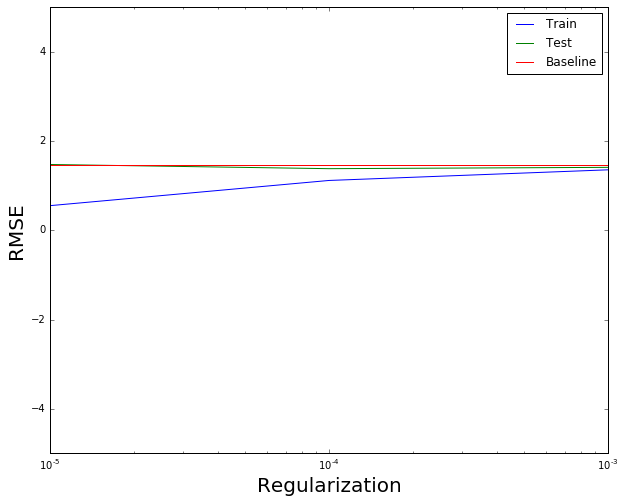

In [20]:
#plot to see the suitable regularisation for our data
(fig, ax) = plt.subplots(figsize=(10, 8))
[p1, p2, p3] = ax.semilogx(regularization_vals, rmse_train, 
                           regularization_vals, rmse_test, 
                           regularization_vals, len(regularization_vals) * [baseline_rmse]
                           )
ax.set_ylim([-5, 5])
ax.set_xlim([0.00001, 0.001])
ax.set_xlabel('Regularization', fontsize=20)
ax.set_ylabel('RMSE', fontsize=20)
ax.legend([p1, p2, p3], ["Train", "Test", "Baseline"])

In [21]:
#recommendation model with regularisation factor=0.0001
models1 = gl.factorization_recommender.create(sf, 'reviewerID', 'asin', 'overall',max_iterations=50, num_factors=5, regularization=0.0001)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 1000000 observations with 509678 users and 171185 items.

Data prepared in: 2.23058s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 5        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 125000 / 1000000 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.7368            | 1.44949                                  |

| 1       | 0.3684            | 0.818491                                 |

| 2       | 0.1842            | 0.498224                                 |

| 3       | 0.0921            | 0.891046                                 |

| 4       | 0.04605           | 1.26608                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.1842            | 0.498224                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 72us         | 2.11136           | 1.45305               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 469.686ms    | DIVERGED          | DIVERGED              | 0.1842      |

| RESET   | 674.286ms    | 2.11136           | 1.45305               |             |

| 1       | 1.13s        | DIVERGED          | DIVERGED              | 0.0921      |

| RESET   | 1.35s        | 2.11136           | 1.45305               |             |

| 1       | 1.80s        | DIVERGED          | DIVERGED              | 0.04605     |

| RESET   | 2.00s        | 2.11135           | 1.45305               |             |

| 1       | 2.41s        | 1.9903            | 1.41075               | 0.023025    |

| 2       | 2.66s        | 1.66342           | 1.28972               | 0.00697199  |

| 3       | 2.93s        | 1.58849           | 1.26035               | 0.00410794  |

| 4       | 3.21s        | 1.54918           | 1.24466               | 0.00291179  |

| 5       | 3.46s        | 1.52301           | 1.2341                | 0.00225514  |

| 6       | 3.87s        | 1.50374           | 1.22627               | 0.00184016  |

| 7       | 4.29s        | 1.48855           | 1.22006               | 0.00155417  |

| 11      | 5.25s        | 1.44849           | 1.20353               | 0.000958377 |

| 12      | 5.66s        | 1.44138           | 1.20057               | 0.000874561 |

| 17      | 7.01s        | 1.41447           | 1.18931               | 0.000608483 |

| 22      | 8.32s        | 1.39587           | 1.18147               | 0.000466542 |

| 27      | 9.84s        | 1.38177           | 1.17549               | 0.000378296 |

| 32      | 11.38s       | 1.37047           | 1.17067               | 0.000318124 |

| 37      | 13.08s       | 1.36107           | 1.16665               | 0.000274467 |

| 42      | 14.29s       | 1.35304           | 1.1632                | 0.000241346 |

| 47      | 15.43s       | 1.34606           | 1.1602                | 0.000215358 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.34058

Final training RMSE: 1.15783

In [27]:
#Using the model to predict the rating
sf_test['prediction']=models1.predict(sf_test)
print sf_test
print len(sf_test)

+-------------------------------+-------------------------------+---------------+
|           reviewerID          |              asin             |   prediction  |
+-------------------------------+-------------------------------+---------------+
| f0ce42c52f549e542b28cb6351... | 6116d31a297ceb0f8f69f6f71e... | 3.75042450036 |
| b3deb19947aca2ba8b1603d68f... | fddffbdc4069e184e0fa1192d2... |  2.7580649292 |
| f14792f1e384c11d8b7e6888c3... | 13132c29b5bca0c7d8521c5717... | 3.67765810694 |
| 9daf8337517fcebd589d5ff236... | 13132c29b5bca0c7d8521c5717... | 3.45295241083 |
| 0a770f7985c27615807712f18c... | 13132c29b5bca0c7d8521c5717... | 3.45295241083 |
| 65933ec19897c04d509baaefec... | 13132c29b5bca0c7d8521c5717... | 3.26720952596 |
| c2b1afb33461106241a366abd9... | 13132c29b5bca0c7d8521c5717... | 3.78166755642 |
| bf8ce25785dd389d79e9cf7034... | 13132c29b5bca0c7d8521c5717... | 3.69939292575 |
| 875e7c0bc62bf6aabe06f0dad9... | 362455b1ea124d0f5739a95182... | 3.11729804221 |
| 2593651d510e1d

In [28]:
#converting Sframe to Dataframe
predictiondf = sf_test.to_dataframe()
print predictiondf
print len(predictiondf)
#writing datafarme to csv 
predictiondf.to_csv('predictiondf.csv',index=False, cols=('reviewerID','asin','prediction'))

                                              reviewerID  \
0      f0ce42c52f549e542b28cb6351b93814be2c571809bca8...   
1      b3deb19947aca2ba8b1603d68fd58e381b5d7d22895147...   
2      f14792f1e384c11d8b7e6888c38f7c481853c2b4025c8a...   
3      9daf8337517fcebd589d5ff2366ac45a24a5b6444f991d...   
4      0a770f7985c27615807712f18c410cce9207f4d5e7800c...   
5      65933ec19897c04d509baaefecf025c23012ace8d2b404...   
6      c2b1afb33461106241a366abd95f9d2a795b7e5f76f4d9...   
7      bf8ce25785dd389d79e9cf7034f89bb222cd20a256be4f...   
8      875e7c0bc62bf6aabe06f0dad98e334aca5d15d57f0954...   
9      2593651d510e1d7f1a39eae9925a0c16283d42a75316be...   
10     6c70b33487f267ad731254e79d93313baf9cc99d3eb61d...   
11     4f85a79343b74b15927dd9be80f8d3eb77b85b00944030...   
12     63b7eab98fa43e6be723b28ca682ed738a0913154a9495...   
13     e6caa463ed1cc15202c9abb37e48030675d2655d684035...   
14     da819c4c97f2f8247c9a1eaaaa74456804032d9dc27569...   
15     cbd601ac4ff3c7e410db97a324c3c8e44

In [30]:
#writing the calculated prediction to txt file
predictions = open("predictions_Rating_graphlab.txt", 'w')
k=0
for l in open("pairs_Rating.txt"):
    if l.startswith("reviewerID"):
    #header
        predictions.write(l)
        continue
    u,i = l.strip().split('-')
    predictions.write(u + '-' + i + ',' + str(predictiondf['prediction'][k]) + '\n')
    k+=1
predictions.close()


In [1]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("/Users/vsanghvi007/Github/theme/custom.css", "r").read()
    return HTML(styles)
css_styling()